# Time Series Analysis

# Goal: 
Find outliers, trends and periodicity in the MTA turnstile data

# Data:
The data used in this study, which was organized by Sina Kashuk at CUSP, is a complete dataset of rides logged by card swipes for 600 Manhattan stations. Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks starting from 05/21/2010. It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…).

In [430]:
# Load packages
from IPython.display import Image
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
plt.style.use('ggplot')

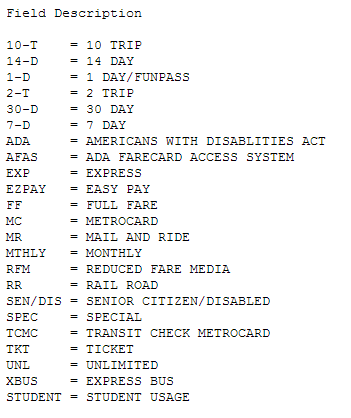

In [431]:
# Show the metadata
Image(filename = "Ridetypes.png")

# Data Preprocessing

In [432]:
# Load the mta dataset and check the size and type
mtarides = np.load("MTA_Fare.npy")
print(mtarides.shape, mtarides.dtype)

((600, 23, 194), dtype('int32'))


In [433]:
# The missing values were '-1' in the data, recast the data to float type and convert '-1' to nan
mtarides = mtarides.astype('float')
mtarides[mtarides==-1] = np.nan

In [434]:
# Average over stations
mtarides_station = np.nanmean(mtarides, axis=0)
# Average over types
mtarides_types = np.nanmean(mtarides, axis=1)
# Average over both stations and types
mtarides_ts = np.nanmean(mtarides_types, axis=0)

In [435]:
# Define ride types according to the metadata shown above.
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez', 'ff', 'mc', 'mr', 
                     'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't', 'umlim', 'xbus', 'stud'])

In [436]:
# Generate date index for the data, defining each week start on Friday in this problem.
start = '2010-05-21'
end = '2014-02-21'
dateindex = pd.date_range(start=start, end=end, freq='W-FRI')

In [437]:
dateindex

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-12-20', '2013-12-27', '2014-01-03', '2014-01-10',
               '2014-01-17', '2014-01-24', '2014-01-31', '2014-02-07',
               '2014-02-14', '2014-02-21'],
              dtype='datetime64[ns]', length=197, freq='W-FRI')

Since there should only be 194 week for the data, the date index is not used for now.

# Event Detection

In [438]:
# Create a dataframe to analyze the overall swipe data
df_ts=pd.DataFrame({'week': np.linspace(1,194,194), 'average_number_of_swipes': mtarides_ts})
df_ts.set_index('week', inplace=True)

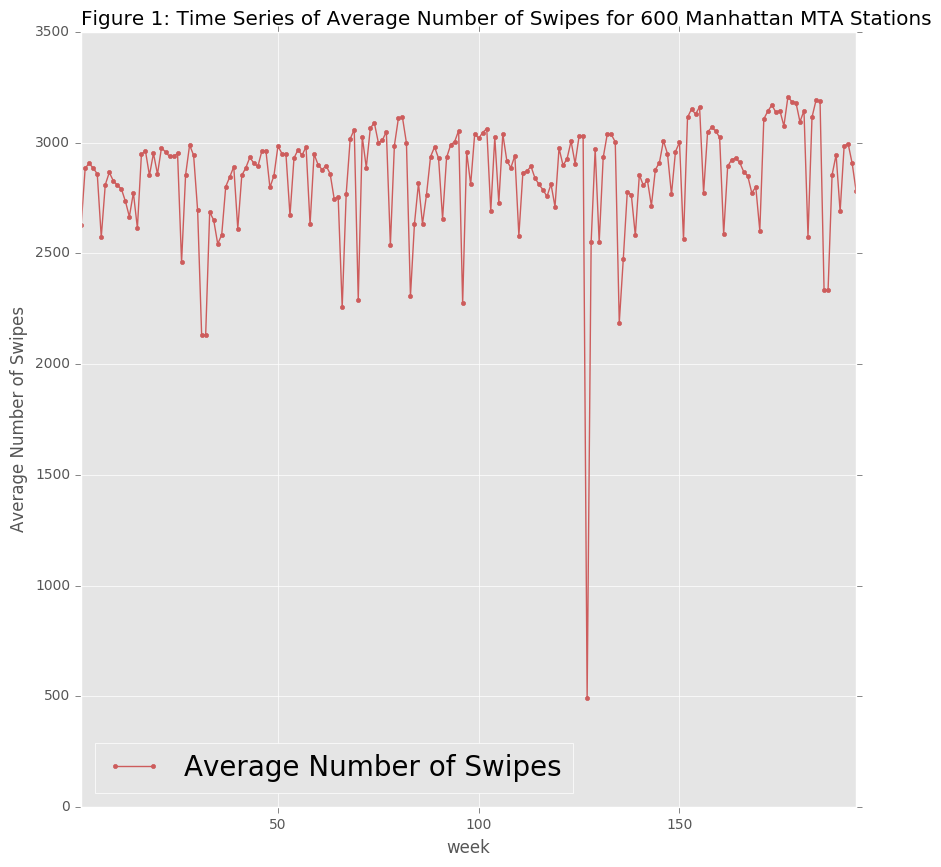

In [439]:
# Plot the average number of swipes time series
ax = df_ts.plot(figsize=(10,10), color="IndianRed", style=".-")
plt.ylabel('Average Number of Swipes')
plt.title('Figure 1: Time Series of Average Number of Swipes for 600 Manhattan MTA Stations', loc='left')
plt.legend(['Average Number of Swipes'], fontsize=20, loc=3)
plt.show()

Figure 1: Time Series of Average Number of Swipes for 600 Manhattan MTA Stations. Data used: rides logged by card swipes for 600 Manhattan stations per week for 194 weeks from 05/21/2010 to 02/21/2014. Weeks with missing values for any stations are excluded. Frome Figure 1 it can be visually inspected that there are extreme events in terms of average number of swipes in Manhattan during the studied time period.

# Find the most prominent events by thresholding with 3 standard deviations

In [440]:
# Calculate the 3 standard deviation thresholds for the average number of swipes time series
print ("Mean average swipes by week: {:.2f}".format(df_ts['average_number_of_swipes'].mean()))
print ("Standard deviation in average swipes by week: {:.2f}".format(df_ts['average_number_of_swipes'].std()))
thresholds = [df_ts['average_number_of_swipes'].mean() + 3 * df_ts['average_number_of_swipes'].std(), 
              df_ts['average_number_of_swipes'].mean() - 3 * df_ts['average_number_of_swipes'].std()]
print ("3-sigma thresholds: [{:.2f}, {:.2f}]".format(*thresholds))

Mean average swipes by week: 2848.58
Standard deviation in average swipes by week: 269.92
3-sigma thresholds: [3658.34, 2038.82]


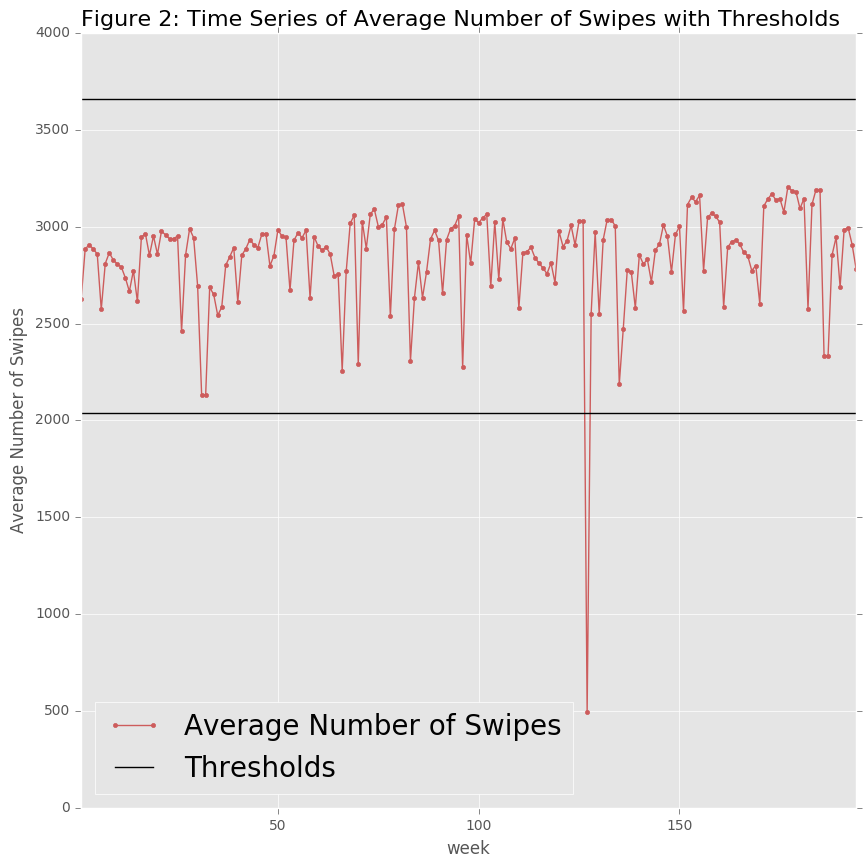

In [441]:
# Visualize the thresholds with the time series plot
ax = df_ts.plot(figsize=(10,10), color="IndianRed", style=".-")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]], color='k')
plt.ylabel('Average Number of Swipes')
plt.title('Figure 2: Time Series of Average Number of Swipes with Thresholds', loc='left', fontsize=16)
plt.legend(['Average Number of Swipes', 'Thresholds'], fontsize=20, loc=3)
plt.show()

Figure 2: Time Series of Average Number of Swipes with Thresholds. By adding threshold lines three standard deviations from the mean, one most prominent event has been spotted during October, 2012.

In [442]:
# Find the exact week for the most prominent event of the time series
print(df_ts[(df_ts['average_number_of_swipes'] < thresholds[1])])

       average_number_of_swipes
week                           
127.0                493.259546


The most prominent event happens at week 127, which is around October/November of 2012. It is suspected that this dramatic drop in average number of weekly swipes was due to Hurricane Sandy(http://www.nydailynews.com/new-york/hurricane-sandy-hits-new-york-city-2012-article-1.2416531). According to the news content in the link above, this event should happen around 2012-10-29. Assuming the week is defined as starting at each Friday, the date index for each starting Friday for the data can be identified by assuming this event happends at the week starting on Oct 26, 2012.

In [443]:
# Re-generate date index for the data
start = pd.date_range(periods=127, end='2012-10-26', closed='right', freq='W-FRI')[0]
dateindex = pd.date_range(start=start, periods=194, freq='W-FRI')

In [444]:
dateindex

DatetimeIndex(['2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
               '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
               '2010-07-23', '2010-07-30',
               ...
               '2013-12-06', '2013-12-13', '2013-12-20', '2013-12-27',
               '2014-01-03', '2014-01-10', '2014-01-17', '2014-01-24',
               '2014-01-31', '2014-02-07'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

# Trend Detection

In [445]:
# Make a dataframe with index of date and columns of ridetype averaging over 600 stations.
df_ridetype = pd.DataFrame(mtarides_station.T, columns=ridetype, index=dateindex)

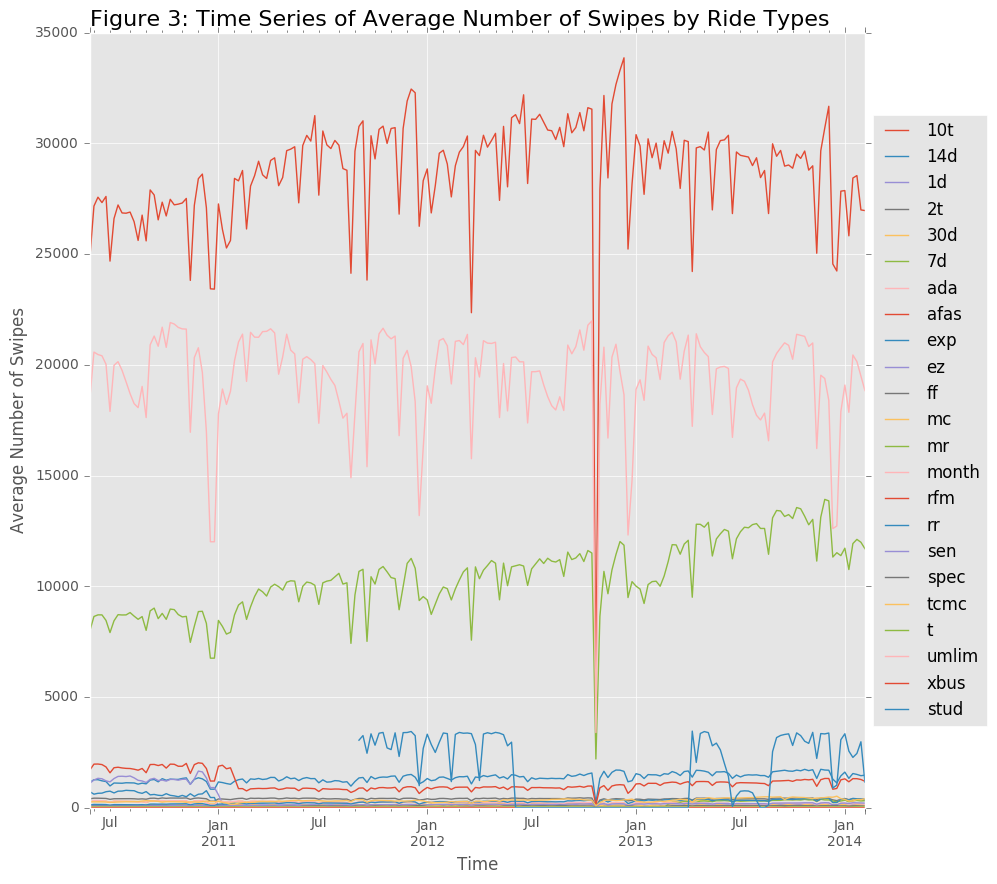

In [446]:
# Plot time series of 23 ridetypes.
ax = df_ridetype.plot(figsize=(10,10))
plt.ylabel('Average Number of Swipes')
plt.xlabel('Time')
plt.title('Figure 3: Time Series of Average Number of Swipes by Ride Types', loc='left', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

It is found that plotting all 23 ridetypes time series in one plot is not a good presentation for trend detection as they have different magnitudes. To visualize the time series clearly, two measures will be taken. First, all time series will be smoothed using a rolling mean of 10 data points. Second, every five/six time series will be plotted for each figure. 

# Use of rolling mean to visually detect stationarity

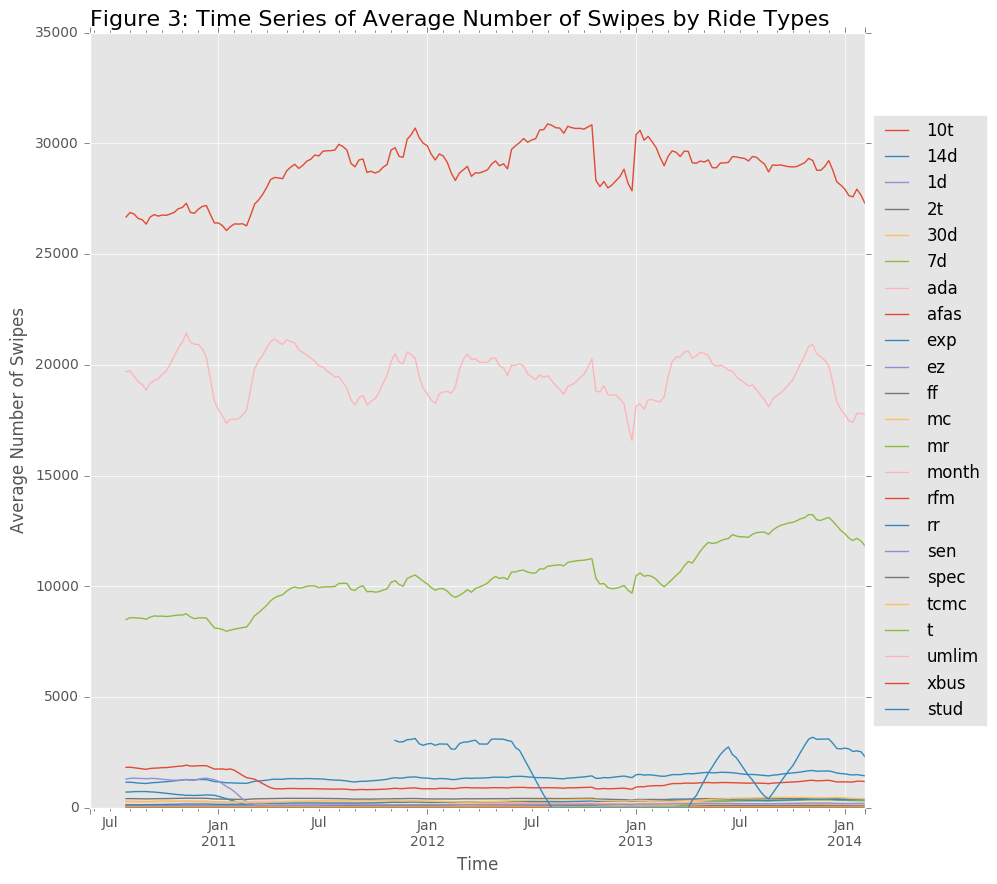

In [447]:
# Use rolling mean with a window of 10 data points.
ax = df_ridetype.rolling(window=10,center=False).mean().plot(figsize=(10,10))
plt.ylabel('Average Number of Swipes')
plt.xlabel('Time')
plt.title('Figure 3: Time Series of Average Number of Swipes by Ride Types', loc='left', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

From Figure 3 it can be found that time series of different ride types are quite different in terms of magnitude as well as trend. To assess the stationarity of these time series, Augmented Dickey–Fuller test will be performed per ride type.

# Augmented Dickey–Fuller Test with significance level at 0.05

In [484]:
# Calculate ADFuller test for each time series
ls = [] 
for column in df_ridetype:
    if adfuller(df_ridetype[column].dropna())[1] > 0.05: 
        print('Ride type {}: {}'.format(column, adfuller(df_ridetype[column].dropna())[1]))
        print('Number of observations: {}'.format(adfuller(df_ridetype[column].dropna())[3]))
        print('\n')
        ls.append(column)
    else:
        pass

Ride type 14d: 0.236466450257
Number of observations: 186


Ride type 1d: 0.229994224672
Number of observations: 186


Ride type 7d: 0.529955410481
Number of observations: 186


Ride type afas: 0.0904115582389
Number of observations: 181


Ride type ez: 0.120667984883
Number of observations: 179


Ride type ff: 0.528910378627
Number of observations: 190


Ride type mc: 0.87380773794
Number of observations: 185


Ride type mr: 0.928736095048
Number of observations: 193


Ride type month: 0.543733386703
Number of observations: 186


Ride type rfm: 0.230316069234
Number of observations: 184


Ride type rr: 0.755836105349
Number of observations: 186


Ride type sen: 0.733680074561
Number of observations: 186


Ride type spec: 0.0711910890681
Number of observations: 190


Ride type xbus: 0.396765855767
Number of observations: 186


Ride type stud: 0.0867631332439
Number of observations: 125




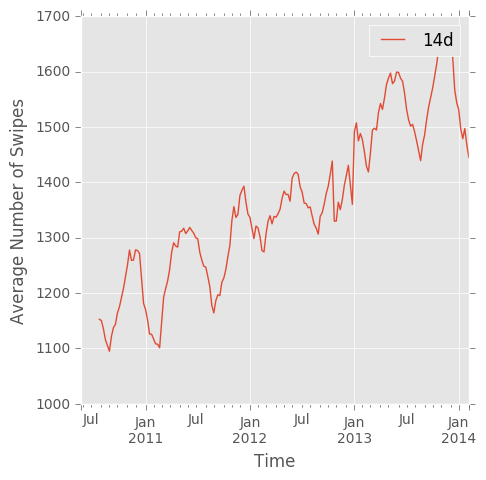

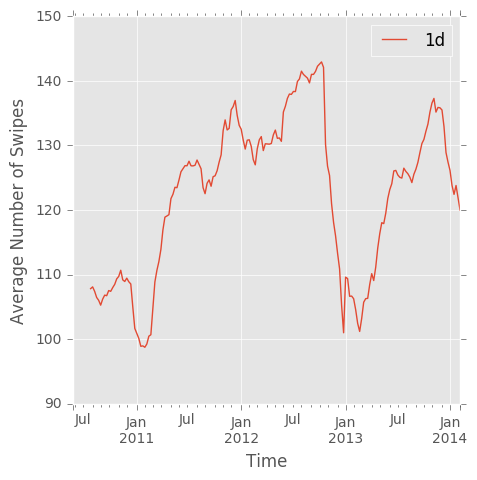

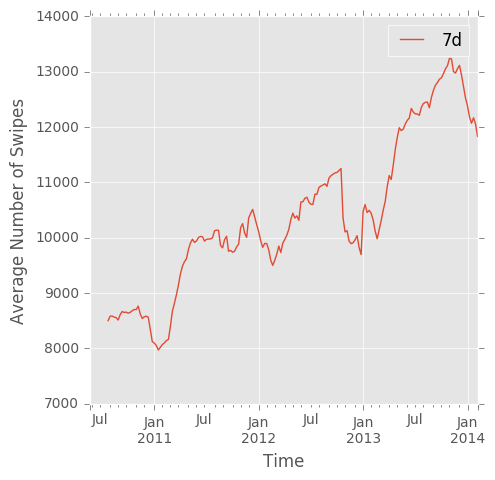

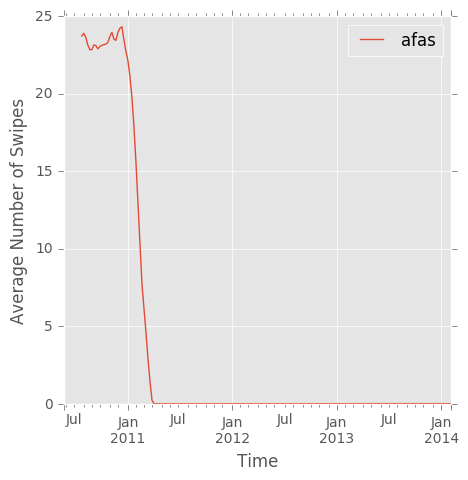

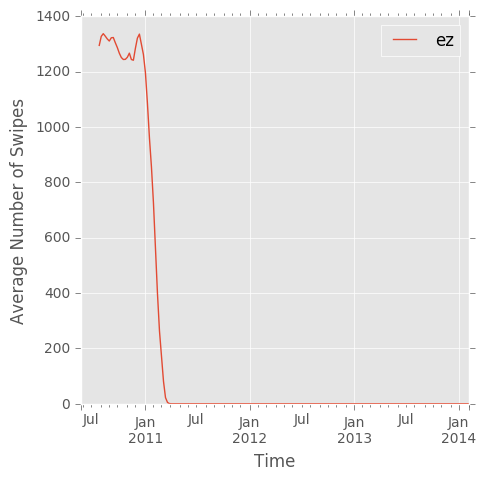

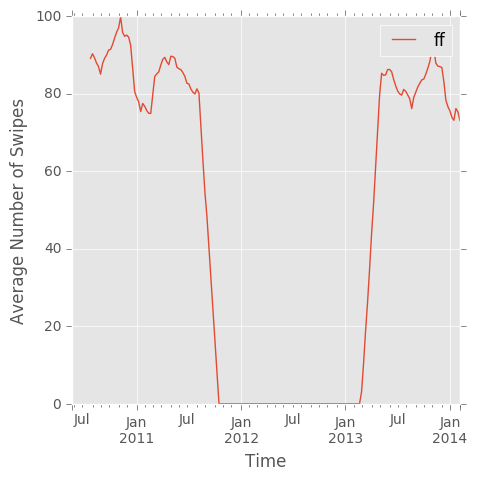

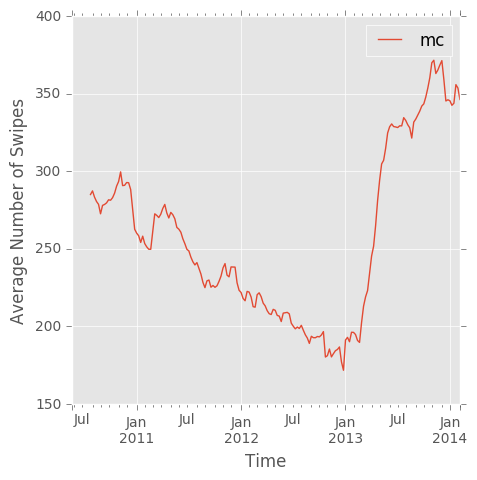

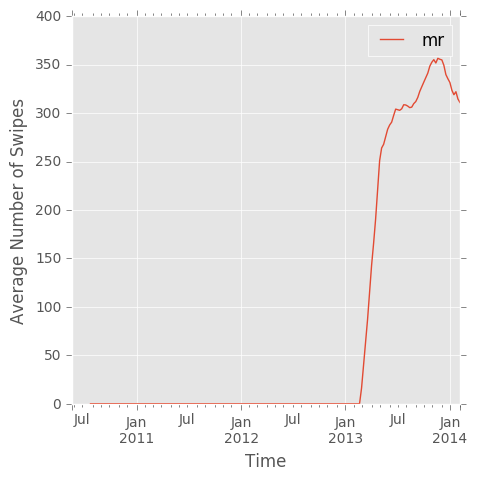

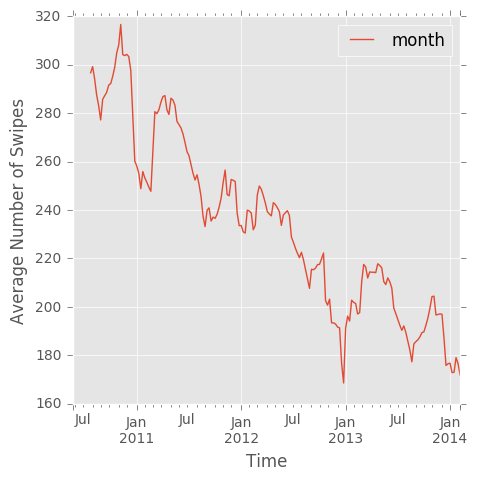

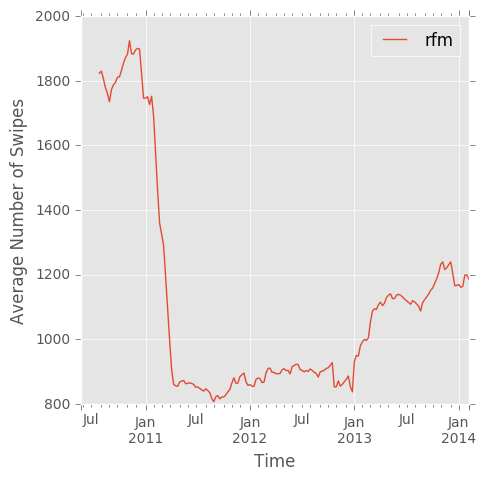

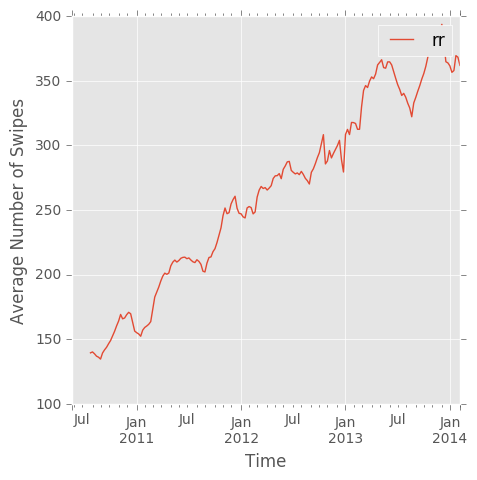

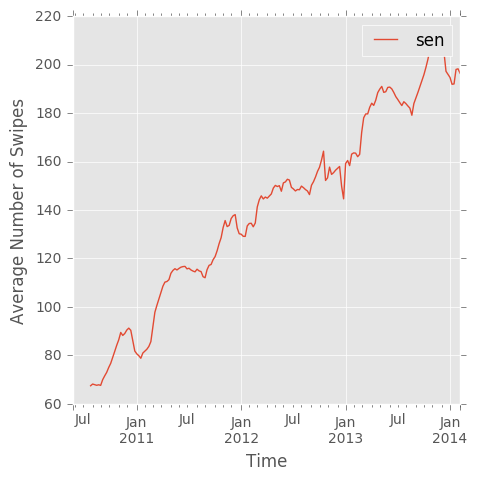

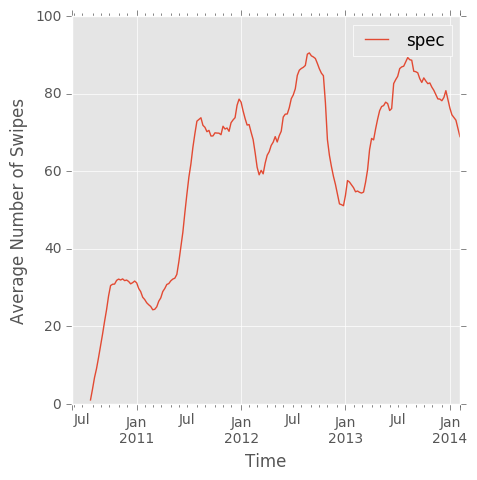

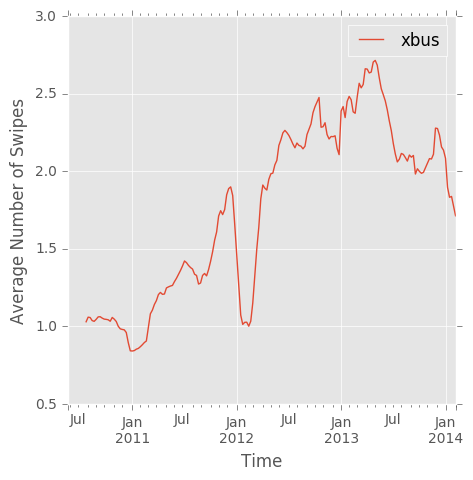

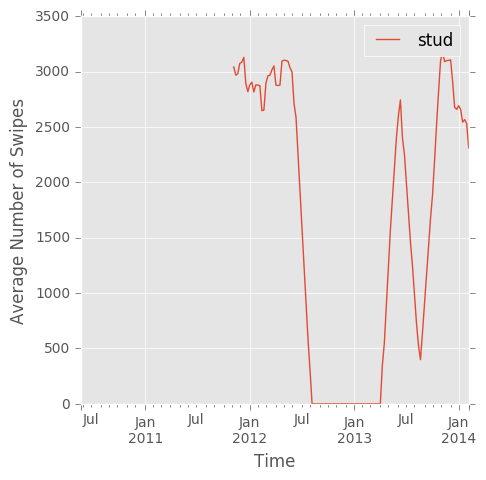

In [480]:
# Plot the selected time series with rolling mean of 10 data points to visually verify theri non-stationarity
df_ridetype_selected = df_ridetype[ls]
for column in df_ridetype_selected:
    ax = df_ridetype[column].rolling(window=10,center=False).mean().plot(figsize=(5,5))
    plt.ylabel('Average Number of Swipes')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

From the above results it can be found that several ridetype time series have very low number of swipes or simply nan for a long period of time. This is due to the missing data introduced during the aggregation of individual station time series. Therefore, these time series, namely afas, ez, ff, mr, stud, cannot be regarded as non-stationary, nor stationary, as there is a lack of data to support both arguments.

In [489]:
# Delete ridetype time series with missing data or near-zero data
df_ridetype_selected = df_ridetype_selected.drop(['afas', 'ez', 'ff', 'mr', 'stud'], axis=1)

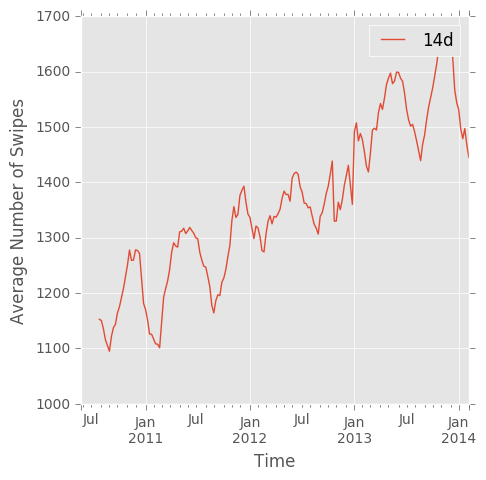

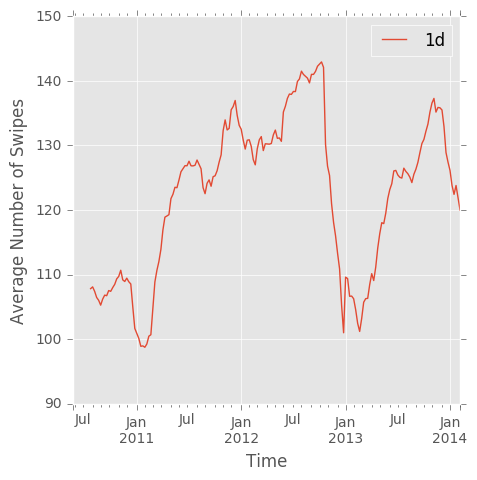

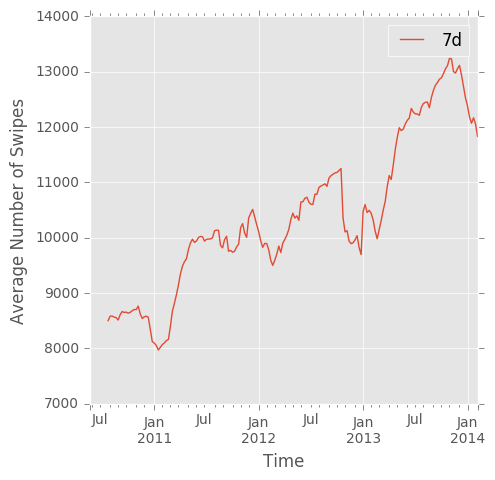

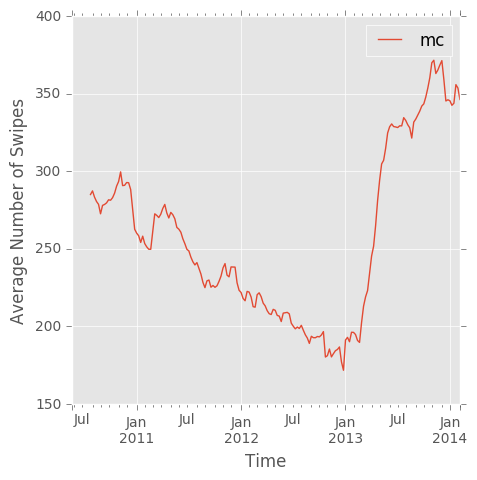

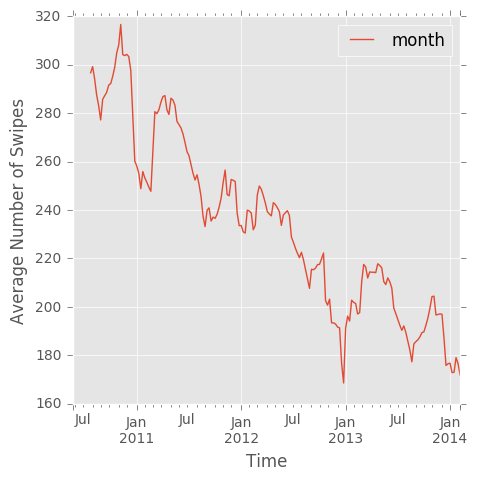

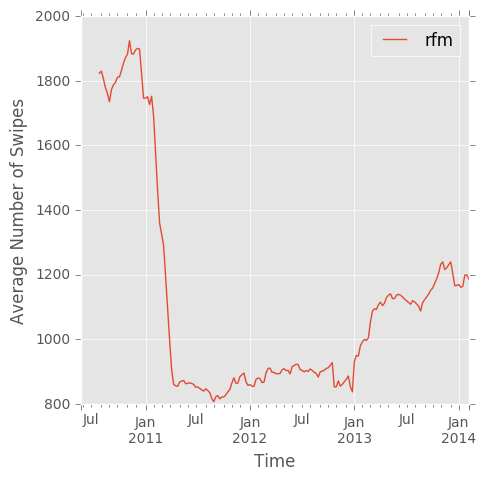

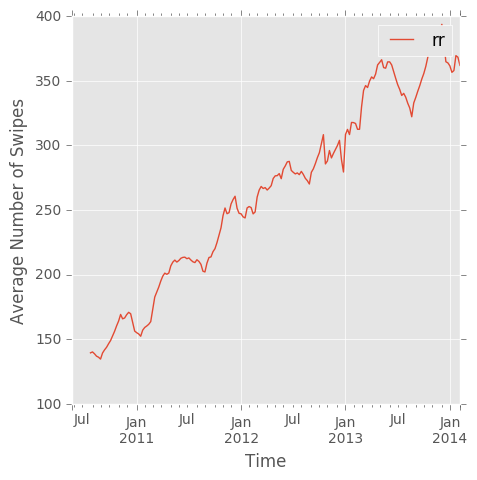

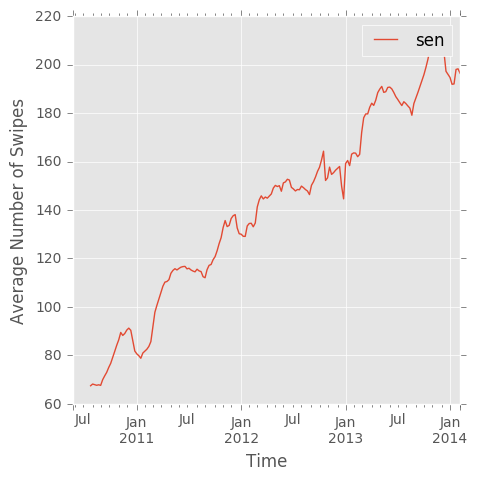

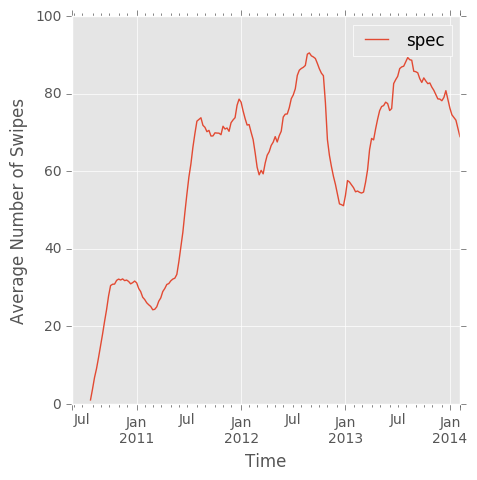

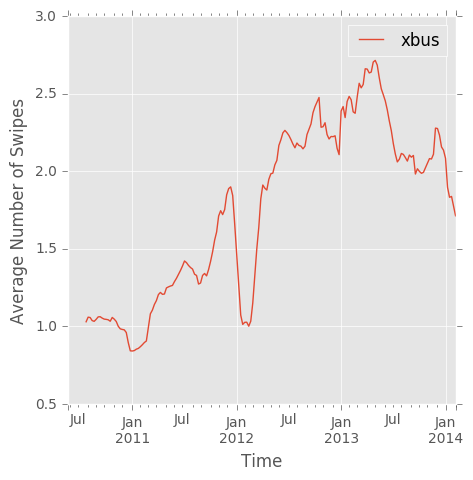

In [490]:
# Re-plot non-stationary ridetypes data of rolling mean of 10 data points
for column in df_ridetype_selected:
    ax = df_ridetype[column].rolling(window=10,center=False).mean().plot(figsize=(5,5))
    plt.ylabel('Average Number of Swipes')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

In [521]:
# Calculate the ratio of average number of swipes in the first and last 10 weeks excluding nan values, and identify if the 
# trend is increasing or decreasing.
for column in df_ridetype_selected:
    ratio = (df_ridetype[column].rolling(window=10,center=False).mean()[193] / 
             df_ridetype[column].rolling(window=10,center=False).mean()[9])
    if ratio > 1:
        trend = 'increasing'
    else:
        trend = 'decreasing'
    print('Ride type: {}'.format(column))
    print('Trend: {}'.format(trend))
    print('Ratio: {}'.format(round(ratio, 2)))
    print('\n')

Ride type: 14d
Trend: increasing
Ratio: 1.25


Ride type: 1d
Trend: increasing
Ratio: 1.11


Ride type: 7d
Trend: increasing
Ratio: 1.39


Ride type: mc
Trend: increasing
Ratio: 1.22


Ride type: month
Trend: decreasing
Ratio: 0.58


Ride type: rfm
Trend: decreasing
Ratio: 0.65


Ride type: rr
Trend: increasing
Ratio: 2.6


Ride type: sen
Trend: increasing
Ratio: 2.91


Ride type: spec
Trend: increasing
Ratio: 70.31


Ride type: xbus
Trend: increasing
Ratio: 1.66




According to the analysis above, ride type 14d, 1d, 7d, mc, rr, sen, spec and xbus are increasing over time, ride type month, rfm are decreasing.

# Periodicity Identification

In [665]:
# Transpose the data matrix for each station 
arr_station = mtarides_types.T

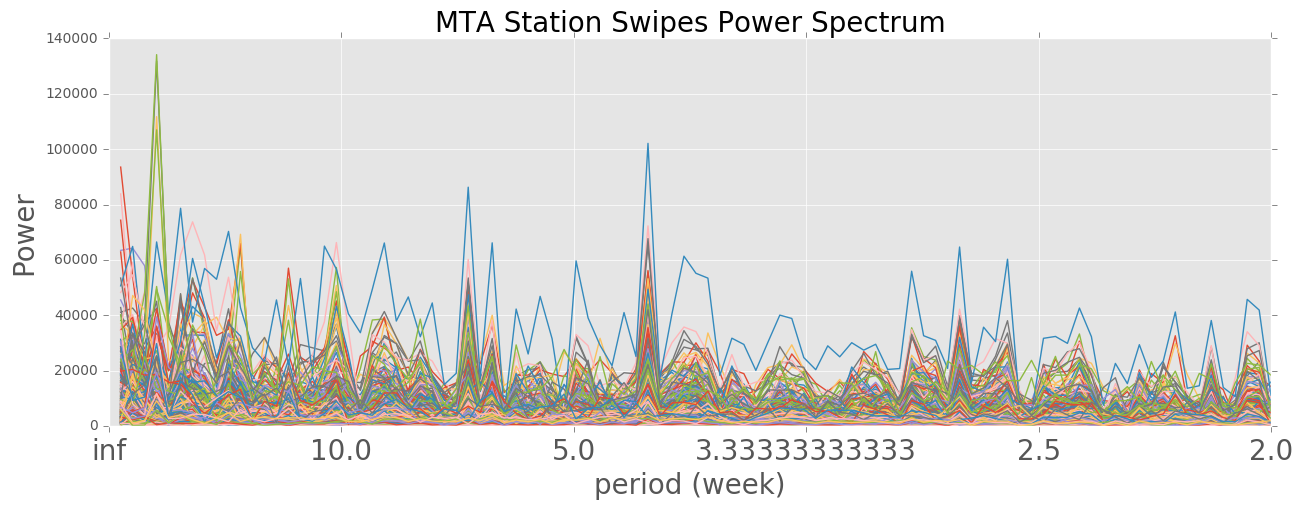

In [686]:
# Plot the power spectrum, and record the power value of each station at a period of 48.5 weeks 
# as an approximity for annual periodicity.
ls = []
fig=plt.figure(figsize=(15,5))
for station in range(arr_station.shape[1]):
    f = np.abs(np.fft.rfft(arr_station[:, station]))
    ax=fig.add_subplot(111)
    ax.plot(np.fft.rfftfreq(arr_station.shape[0], 1.0)[1:], (f[1:]), '-')
    ls.append(f[4])
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.xlabel("period (week)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.title("MTA Station Swipes Power Spectrum", fontsize=20)
plt.show()

In [749]:
# Select the top 4 stations with most 
arr_power = np.array(zip(range(600), ls))
arr_power = arr_power[~np.isnan(arr_power[:,1])]
top_4station = sorted(arr_power, reverse=True, key=lambda x: x[1])[:4]
print('The top 4 station number of most prominent periodic trend on an annual period: {}, {}, {}, {}'
      .format(int(top_4station[0][0]), int(top_4station[1][0]), int(top_4station[2][0]), int(top_4station[3][0])))

The top 4 station number of most prominent periodic trend on an annual period: 194, 150, 32, 327


In [763]:
plt.legend?

In [779]:
arr_station

array([[ 5767.18181818,  1695.72727273,   300.27272727, ...,
                   nan,            nan,            nan],
       [ 6794.40909091,  2112.        ,   312.77272727, ...,
                   nan,            nan,            nan],
       [ 6926.5       ,  2243.59090909,   328.59090909, ...,
                   nan,            nan,            nan],
       ..., 
       [ 3430.47826087,            nan,   355.26086957, ...,
                   nan,            nan,            nan],
       [ 3243.08695652,            nan,   343.7826087 , ...,
                   nan,            nan,            nan],
       [ 3340.56521739,            nan,   295.2173913 , ...,
                   nan,            nan,            nan]])

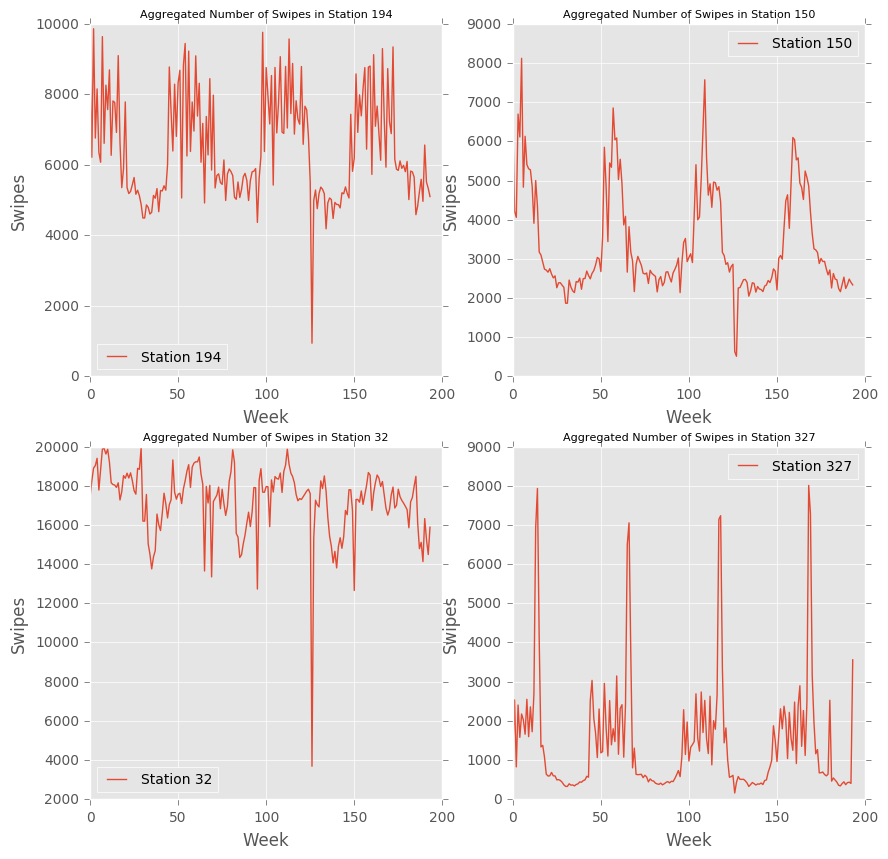

In [787]:
# Plot the four selected station time series
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1 = plt.plot(arr_station[:, 194])
ax1 = plt.legend(['Station 194'], fontsize=10, loc='best')
ax1 = plt.title('Aggregated Number of Swipes in Station 194', fontsize=8)
ax1 = plt.xlabel('Week')
ax1 = plt.ylabel('Swipes')

ax2 = fig.add_subplot(222)
ax2 = plt.plot(arr_station[:, 150])
ax2 = plt.legend(['Station 150'], fontsize=10, loc='best')
ax2 = plt.title('Aggregated Number of Swipes in Station 150', fontsize=8)
ax2 = plt.xlabel('Week')
ax2 = plt.ylabel('Swipes')

ax3 = fig.add_subplot(223)
ax3 = plt.plot(arr_station[:, 32])
ax3 = plt.legend(['Station 32'], fontsize=10, loc='best')
ax3 = plt.title('Aggregated Number of Swipes in Station 32', fontsize=8)
ax3 = plt.xlabel('Week')
ax3 = plt.ylabel('Swipes')

ax4 = fig.add_subplot(224)
ax4 = plt.plot(arr_station[:, 327])
ax4 = plt.legend(['Station 327'], fontsize=10, loc='best')
ax4 = plt.title('Aggregated Number of Swipes in Station 327', fontsize=8)
ax4 = plt.xlabel('Week')
ax4 = plt.ylabel('Swipes')

plt.show()

According to the above analysis, the four stations with most prominant annual periodicity have been found as station 194, 150, 32, 327. Visually inspected, it is found that the annual trend is largely due to the climate seasonality, i.e. during warmer weeks people tend to use MTA services more frequently.